# Process (insert correctors)

In [ ]:
import re

def process(line, table):
    match = re.match(r'^(\w+(\.\w+)*): (.+?), L=([\d.]+),?( ANGLE=([\d.]+))?(.*)$', line)
    groups = match.groups()
    name, _, kind, length, _, angle, text = groups
    tail, *text = [*map(str.strip, text.split('!'))]
    if '!' not in line:
        if angle:
            return [f'"{name}": {kind}, L={length}, ANGLE={angle}{tail}']
        return [f'"{name}": {kind}, L={length}, {tail}'] if tail != ';' else [f'"{name}": {kind}, L={length}{tail}']
    text, *_ = text
    table[name] = [name, *text.split(), name]
    point = [f'"{point}": MULTIPOLE, L=0.0;' for point in text.split()]
    length = str(float(length)/2)
    if angle:
        angle = str(float(angle)/2)
        line = f'"{name}": {kind}, L={length}, ANGLE={angle}{tail}'
        return [line, *point]
    else:
        line = f'"{name}": {kind}, L={length}, {tail}' if tail != ';' else f'"{name}": {kind}, L={length}{tail}'
        return [line, *point]

In [ ]:
sequence = ''
lattice = []
table = {}
flag = True
with open('vepp4m-exp-all.madx', 'r') as stream:
    for line in stream:
        if 'LINE' in line:
            flag = False
        if flag:
            lattice.append(process(line, table))
        else:
            sequence += '\n' + line
lattice = '\n'.join(set(sum(lattice, start=[])))
sequence = sequence.replace('\n', '')
name, sequence = sequence.split(':')
sequence = [*map(str.strip, re.search(r'LINE=\((.*?)\)', sequence).group(1).split(','))]
sequence = sum([table.get(element, [element]) for element in sequence], start=[])
sequence = f'{name}: LINE=("' + '", "'.join(sequence) + '");'
out = lattice + '\n' +  sequence
with open('vepp4m-exp-out.madx', 'w') as file:
    file.write(out.upper())

In [ ]:
sequence = ''
lattice = []
table = {}
flag = True
with open('vepp4m-inj-all.madx', 'r') as stream:
    for line in stream:
        if 'LINE' in line:
            flag = False
        if flag:
            lattice.append(process(line, table))
        else:
            sequence += '\n' + line
lattice = '\n'.join(set(sum(lattice, start=[])))
sequence = sequence.replace('\n', '')
name, sequence = sequence.split(':')
sequence = [*map(str.strip, re.search(r'LINE=\((.*?)\)', sequence).group(1).split(','))]
sequence = sum([table.get(element, [element]) for element in sequence], start=[])
sequence = f'{name}: LINE=("' + '", "'.join(sequence) + '");'
out = lattice + '\n' +  sequence
with open('vepp4m-inj-out.madx', 'w') as file:
    file.write(out.upper())

# Build (config from elegant twiss table)

In [1]:
rise = {'STP2': 8, 'STP4': 8, 'SRP1': 8, 'SRP2': 8, 'SRP3': 8, 'SRP4': 8, 'SRP5': 8, 'SRP6': 8, 'SRP7': 8, 'SRP8': 8, 'SRP9': 9, 'SIP1': 9, 'SIP2': 9, 'SRP10': 9, 'SRP11': 9, 'SRP12': 9, 'SRP13': 9, 'SRP14': 8, 'SRP15': 8, 'SRP16': 8, 'SRP17': 8, 'SEP5': 9, 'SEP4': 9, 'SEP3': 9, 'SEP1': 9, 'SEP0': 9, 'NEP0': 9, 'NEP1': 9, 'NEP3': 9, 'NEP4': 9, 'NEP5': 9, 'NRP17': 9, 'NRP16': 9, 'NRP15': 9, 'NRP14': 9, 'NRP13': 9, 'NRP12': 9, 'NRP11': 9, 'NRP10': 9, 'NIP3': 9, 'NIP1': 9, 'NRP9': 9, 'NRP8': 9, 'NRP7': 9, 'NRP6': 9, 'NRP5': 9, 'NRP4': 9, 'NRP3': 9, 'NRP2': 9, 'NRP1': 9, 'NTP4': 9, 'NTP2': 9, 'NTP0': 9, 'STP0': 9}

def generate(file, *, rise=rise, kinds={'MARK': 'MONITOR', 'MULT': 'VIRTUAL'}):
    NAME = !(sdds2stream -col=ElementName $file)
    KIND = !(sdds2stream -col=ElementType $file)
    TIME = !(sdds2stream -col=s $file)
    NAME = [*map(str.strip, NAME)]
    KIND = [*map(str.strip, KIND)]
    TIME = [*map(str.strip, TIME)]

    AX = !(sdds2stream -col=alphax $file)
    BX = !(sdds2stream -col=betax $file)
    FX = !(sdds2stream -col=psix $file)
    DX = !(sdds2stream -col=etax $file)
    PX = !(sdds2stream -col=etaxp $file)
    AX = [*map(str.strip, AX)]
    BX = [*map(str.strip, BX)]
    FX = [*map(str.strip, FX)]
    DX = [*map(str.strip, DX)]
    PX = [*map(str.strip, PX)]

    AY = !(sdds2stream -col=alphay $file)
    BY = !(sdds2stream -col=betay $file)
    FY = !(sdds2stream -col=psiy $file)
    DY = !(sdds2stream -col=etay $file)
    PY = !(sdds2stream -col=etayp $file)
    AY = [*map(str.strip, AY)]
    BY = [*map(str.strip, BY)]
    FY = [*map(str.strip, FY)]
    DY = [*map(str.strip, DY)]
    PY = [*map(str.strip, PY)]
    
    TABLE = {}
    LID = 0
    KID = 0
    for data in  zip(NAME, KIND, TIME, AX, BX, FX, DX, PX, AY, BY, FY, DY, PY):
        name, kind, time, ax, bx, fx, dx, px, ay, by, fy, dy, py = data
        if kind not in kinds or name == '_BEG_':
            continue
        table = {
            'NAME':name,
            'LID':LID,
            'KID':KID,
            'TYPE':kinds[kind],
            'FLAG': int(name not in ['HEAD', 'TAIL']),
            'JOIN': int(kinds[kind] == 'MONITOR'),
            'RISE': rise.get(name, -1),
            'TIME': float(time),
            'AX': float(ax), 'BX': float(bx), 'FX': float(fx), 'DX': float(dx), 'PX': float(px),
            'AY': float(ay), 'BY': float(by), 'FY': float(fy), 'DY': float(dy), 'PY': float(py),
            'SIGMA_AX': 0.0, 'SIGMA_BX': 0.0, 'SIGMA_FX': 0.0, 'SIGMA_DX': 0.0, 'SIGMA_PX': 0.0,
            'SIGMA_AY': 0.0, 'SIGMA_BY': 0.0, 'SIGMA_FY': 0.0, 'SIGMA_DY': 0.0, 'SIGMA_PY': 0.0
        }
        if name not in TABLE:
            TABLE[name] = table
            KID +=1
        else:
            table['KID'] = TABLE[name]['KID']
            index = 0
            while True:
                index += 1
                if f'{name}-{index}' not in TABLE:
                    TABLE[f'{name}-{index}'] = table
                    break
        LID += 1
        

    MODEL = ''
    for key, value in TABLE.items():
        MODEL += f'{key:16}:  '
        MODEL += '{'
        MODEL += f'NAME: {value["NAME"]:16}, '
        MODEL += f'TYPE: {value["TYPE"]:16}, '
        MODEL += f'LID: {value["LID"]:4}, '
        MODEL += f'KID: {value["KID"]:4}, '
        MODEL += f'FLAG: {value["FLAG"]:2}, '
        MODEL += f'JOIN: {value["JOIN"]:2}, '
        MODEL += f'RISE: {value["RISE"]:2}, '
        MODEL += f'TIME: {value["TIME"]:24.16E}, '
        MODEL += f'AX: {value["AX"]:24.16E}, '
        MODEL += f'BX: {value["BX"]:24.16E}, '
        MODEL += f'FX: {value["FX"]:24.16E}, '
        MODEL += f'DX: {value["DX"]:24.16E}, '
        MODEL += f'PX: {value["PX"]:24.16E}, '
        MODEL += f'AY: {value["AY"]:24.16E}, '
        MODEL += f'BY: {value["BY"]:24.16E}, '
        MODEL += f'FY: {value["FY"]:24.16E}, '
        MODEL += f'DY: {value["DY"]:24.16E}, '
        MODEL += f'PY: {value["PY"]:24.16E}, '
        MODEL += f'SIGMA_AX: {value["SIGMA_AX"]:24.16E}, '
        MODEL += f'SIGMA_BX: {value["SIGMA_BX"]:24.16E}, '
        MODEL += f'SIGMA_FX: {value["SIGMA_FX"]:24.16E}, '
        MODEL += f'SIGMA_DX: {value["SIGMA_DX"]:24.16E}, '
        MODEL += f'SIGMA_PX: {value["SIGMA_PX"]:24.16E}, '
        MODEL += f'SIGMA_AY: {value["SIGMA_AY"]:24.16E}, '
        MODEL += f'SIGMA_BY: {value["SIGMA_BY"]:24.16E}, '
        MODEL += f'SIGMA_FY: {value["SIGMA_FY"]:24.16E}, '
        MODEL += f'SIGMA_DY: {value["SIGMA_DY"]:24.16E}, '
        MODEL += f'SIGMA_PY: {value["SIGMA_PY"]:24.16E}'
        MODEL += '}\n'

    return MODEL

In [2]:
with open('vepp4m-inj-out.yaml', mode='w') as stream:
    stream.write(generate('vepp4m-inj-out.sdds'))

with open('vepp4m-exp-out.yaml', mode='w') as stream:
    stream.write(generate('vepp4m-exp-out.sdds'))

In [3]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.model import Model

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [5]:
# Load inj and exp models

inj = Model(path='vepp4m-inj-out.yaml')
exp = Model(path='vepp4m-exp-out.yaml')

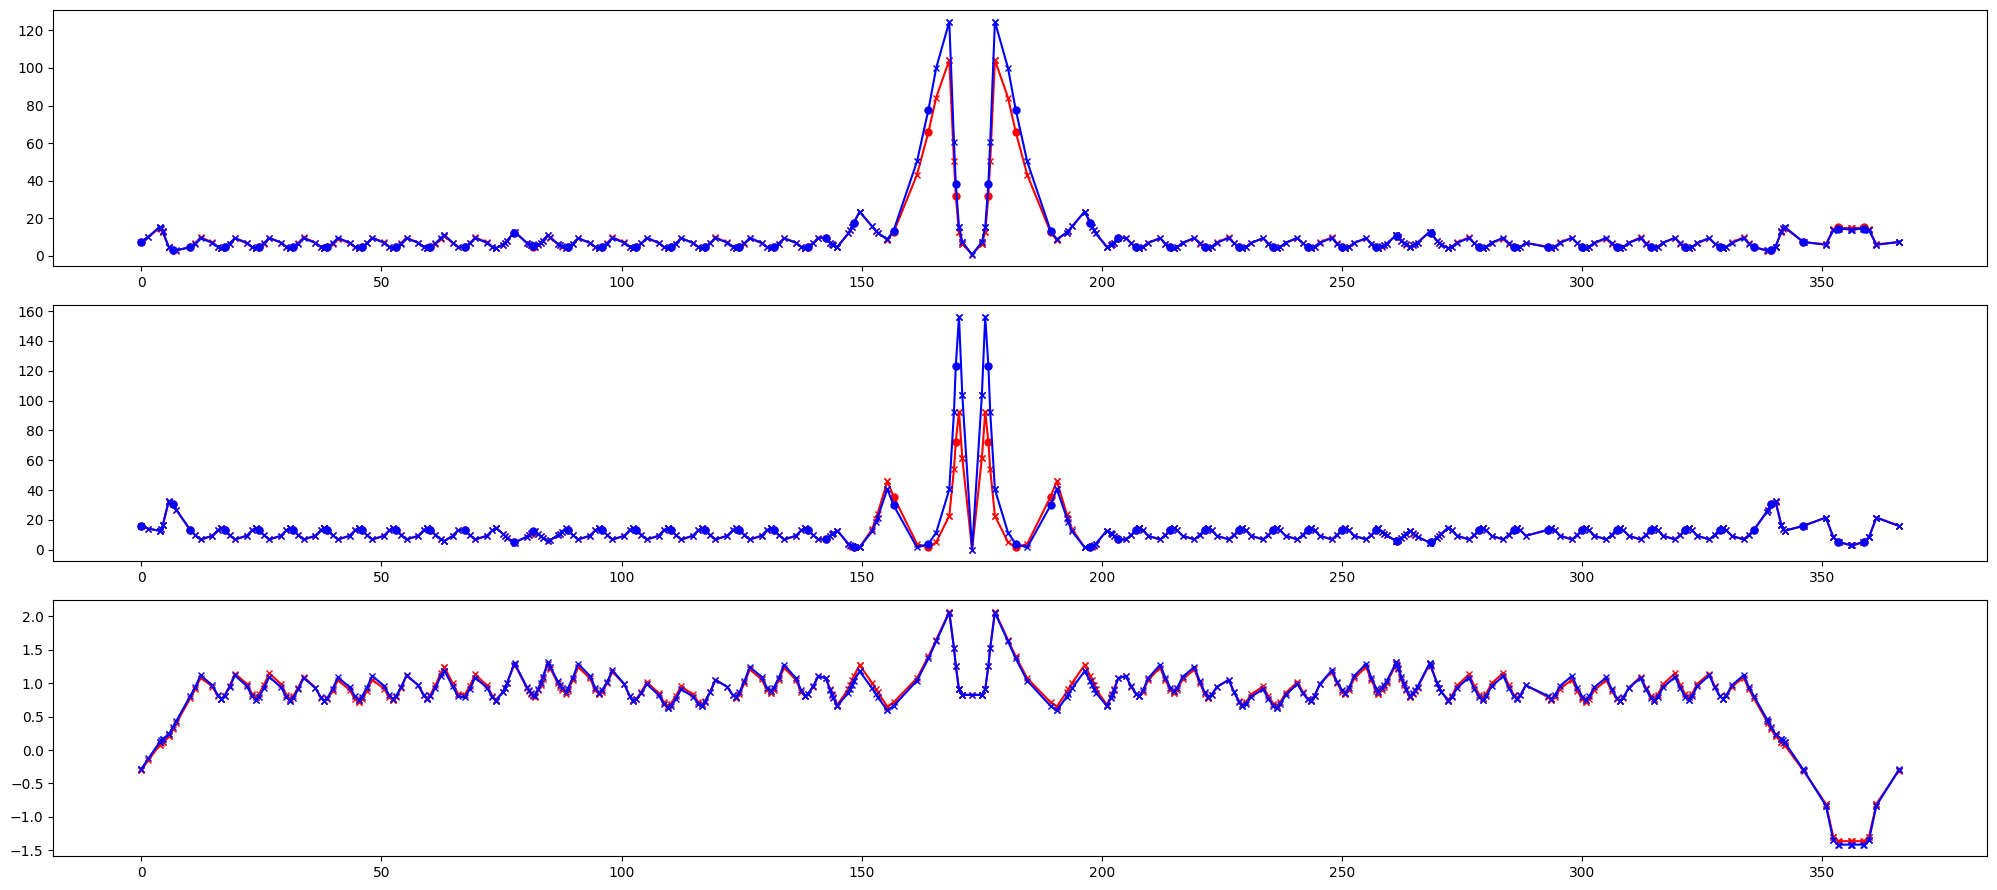

In [6]:
# Compare beta functions and dispersion
# Note, dispersion only accessible via data_frame instance

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 3*3))

ax1.errorbar(inj.time[inj.monitor_index].cpu().numpy(), inj.bx[inj.monitor_index].cpu().numpy(), fmt=' ', marker='o', ms=5, color='red')
ax1.errorbar(inj.time[inj.virtual_index].cpu().numpy(), inj.bx[inj.virtual_index].cpu().numpy(), fmt=' ', marker='x', ms=5, color='red')
ax1.errorbar(inj.time.cpu().numpy(), inj.bx.cpu().numpy(), marker='', ms=5, color='red')
ax1.errorbar(exp.time[exp.monitor_index].cpu().numpy(), exp.bx[exp.monitor_index].cpu().numpy(), fmt=' ', marker='o', ms=5, color='blue')
ax1.errorbar(exp.time[exp.virtual_index].cpu().numpy(), exp.bx[exp.virtual_index].cpu().numpy(), fmt=' ', marker='x', ms=5, color='blue')
ax1.errorbar(exp.time.cpu().numpy(), exp.bx.cpu().numpy(), marker='', ms=5, color='blue')

ax2.errorbar(inj.time[inj.monitor_index].cpu().numpy(), inj.by[inj.monitor_index].cpu().numpy(), fmt=' ', marker='o', ms=5, color='red')
ax2.errorbar(inj.time[inj.virtual_index].cpu().numpy(), inj.by[inj.virtual_index].cpu().numpy(), fmt=' ', marker='x', ms=5, color='red')
ax2.errorbar(inj.time.cpu().numpy(), inj.by.cpu().numpy(), marker='', ms=5, color='red')
ax2.errorbar(exp.time[exp.monitor_index].cpu().numpy(), exp.by[exp.monitor_index].cpu().numpy(), fmt=' ', marker='o', ms=5, color='blue')
ax2.errorbar(exp.time[exp.virtual_index].cpu().numpy(), exp.by[exp.virtual_index].cpu().numpy(), fmt=' ', marker='x', ms=5, color='blue')
ax2.errorbar(exp.time.cpu().numpy(), exp.by.cpu().numpy(), marker='', ms=5, color='blue')

ax3.errorbar(inj.time.cpu().numpy(), inj.data_frame.loc['DX'].values, marker='x', ms=5, color='red')
ax3.errorbar(exp.time.cpu().numpy(), exp.data_frame.loc['DX'].values, marker='x', ms=5, color='blue')

plt.tight_layout()
plt.show()

# Build (config from madx twiss table)

In [7]:
import pandas

rise = {'STP2': 8, 'STP4': 8, 'SRP1': 8, 'SRP2': 8, 'SRP3': 8, 'SRP4': 8, 'SRP5': 8, 'SRP6': 8, 'SRP7': 8, 'SRP8': 8, 'SRP9': 9, 'SIP1': 9, 'SIP2': 9, 'SRP10': 9, 'SRP11': 9, 'SRP12': 9, 'SRP13': 9, 'SRP14': 8, 'SRP15': 8, 'SRP16': 8, 'SRP17': 8, 'SEP5': 9, 'SEP4': 9, 'SEP3': 9, 'SEP1': 9, 'SEP0': 9, 'NEP0': 9, 'NEP1': 9, 'NEP3': 9, 'NEP4': 9, 'NEP5': 9, 'NRP17': 9, 'NRP16': 9, 'NRP15': 9, 'NRP14': 9, 'NRP13': 9, 'NRP12': 9, 'NRP11': 9, 'NRP10': 9, 'NIP3': 9, 'NIP1': 9, 'NRP9': 9, 'NRP8': 9, 'NRP7': 9, 'NRP6': 9, 'NRP5': 9, 'NRP4': 9, 'NRP3': 9, 'NRP2': 9, 'NRP1': 9, 'NTP4': 9, 'NTP2': 9, 'NTP0': 9, 'STP0': 9}

def generate_tfs(file, *, rise=rise, kinds={'MONITOR': 'MONITOR', 'MARKER': 'VIRTUAL'}):
    
    TFS = pandas.read_csv(file, delimiter=r"\s+")

    NAME = TFS['NAME'].tolist()
    KIND = TFS['KEYWORD'].tolist()
    TIME = TFS['S'].tolist()

    AX = TFS['ALFX'].tolist()
    BX = TFS['BETX'].tolist()
    FX = TFS['MUX'].tolist()
    DX = TFS['DX'].tolist()
    PX = TFS['DPX'].tolist()

    AY = TFS['ALFY'].tolist()
    BY = TFS['BETY'].tolist()
    FY = TFS['MUY'].tolist()
    DY = TFS['DY'].tolist()
    PY = TFS['DPY'].tolist()

    TABLE = {}
    LID = 0
    KID = 0
    for data in  zip(NAME, KIND, TIME, AX, BX, FX, DX, PX, AY, BY, FY, DY, PY):
        name, kind, time, ax, bx, fx, dx, px, ay, by, fy, dy, py = data
        if kind not in kinds or name == '_BEG_':
            continue
        table = {
            'NAME':name,
            'LID':LID,
            'KID':KID,
            'TYPE':kinds[kind],
            'FLAG': int(name not in ['HEAD', 'TAIL']),
            'JOIN': int(kinds[kind] == 'MONITOR'),
            'RISE': rise.get(name, -1),
            'TIME': float(time),
            'AX': float(ax), 'BX': float(bx), 'FX': float(fx), 'DX': float(dx), 'PX': float(px),
            'AY': float(ay), 'BY': float(by), 'FY': float(fy), 'DY': float(dy), 'PY': float(py),
            'SIGMA_AX': 0.0, 'SIGMA_BX': 0.0, 'SIGMA_FX': 0.0, 'SIGMA_DX': 0.0, 'SIGMA_PX': 0.0,
            'SIGMA_AY': 0.0, 'SIGMA_BY': 0.0, 'SIGMA_FY': 0.0, 'SIGMA_DY': 0.0, 'SIGMA_PY': 0.0
        }
        if name not in TABLE:
            TABLE[name] = table
            KID +=1
        else:
            table['KID'] = TABLE[name]['KID']
            index = 0
            while True:
                index += 1
                if f'{name}-{index}' not in TABLE:
                    TABLE[f'{name}-{index}'] = table
                    break
        LID += 1

    MODEL = ''
    for key, value in TABLE.items():
        MODEL += f'{key:16}:  '
        MODEL += '{'
        MODEL += f'NAME: {value["NAME"]:16}, '
        MODEL += f'TYPE: {value["TYPE"]:16}, '
        MODEL += f'LID: {value["LID"]:4}, '
        MODEL += f'KID: {value["KID"]:4}, '
        MODEL += f'FLAG: {value["FLAG"]:2}, '
        MODEL += f'JOIN: {value["JOIN"]:2}, '
        MODEL += f'RISE: {value["RISE"]:2}, '
        MODEL += f'TIME: {value["TIME"]:24.16E}, '
        MODEL += f'AX: {value["AX"]:24.16E}, '
        MODEL += f'BX: {value["BX"]:24.16E}, '
        MODEL += f'FX: {value["FX"]:24.16E}, '
        MODEL += f'DX: {value["DX"]:24.16E}, '
        MODEL += f'PX: {value["PX"]:24.16E}, '
        MODEL += f'AY: {value["AY"]:24.16E}, '
        MODEL += f'BY: {value["BY"]:24.16E}, '
        MODEL += f'FY: {value["FY"]:24.16E}, '
        MODEL += f'DY: {value["DY"]:24.16E}, '
        MODEL += f'PY: {value["PY"]:24.16E}, '
        MODEL += f'SIGMA_AX: {value["SIGMA_AX"]:24.16E}, '
        MODEL += f'SIGMA_BX: {value["SIGMA_BX"]:24.16E}, '
        MODEL += f'SIGMA_FX: {value["SIGMA_FX"]:24.16E}, '
        MODEL += f'SIGMA_DX: {value["SIGMA_DX"]:24.16E}, '
        MODEL += f'SIGMA_PX: {value["SIGMA_PX"]:24.16E}, '
        MODEL += f'SIGMA_AY: {value["SIGMA_AY"]:24.16E}, '
        MODEL += f'SIGMA_BY: {value["SIGMA_BY"]:24.16E}, '
        MODEL += f'SIGMA_FY: {value["SIGMA_FY"]:24.16E}, '
        MODEL += f'SIGMA_DY: {value["SIGMA_DY"]:24.16E}, '
        MODEL += f'SIGMA_PY: {value["SIGMA_PY"]:24.16E}'
        MODEL += '}\n'

    return MODEL

In [8]:
with open('twiss-luminosity.yaml', mode='w') as stream:
    stream.write(generate_tfs('twiss-luminosity.tfs'))

In [9]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.model import Model

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [11]:
# Load inj and exp models

exp = Model(path='../vepp4m-exp.yaml')
lum = Model(path='twiss-luminosity.yaml')

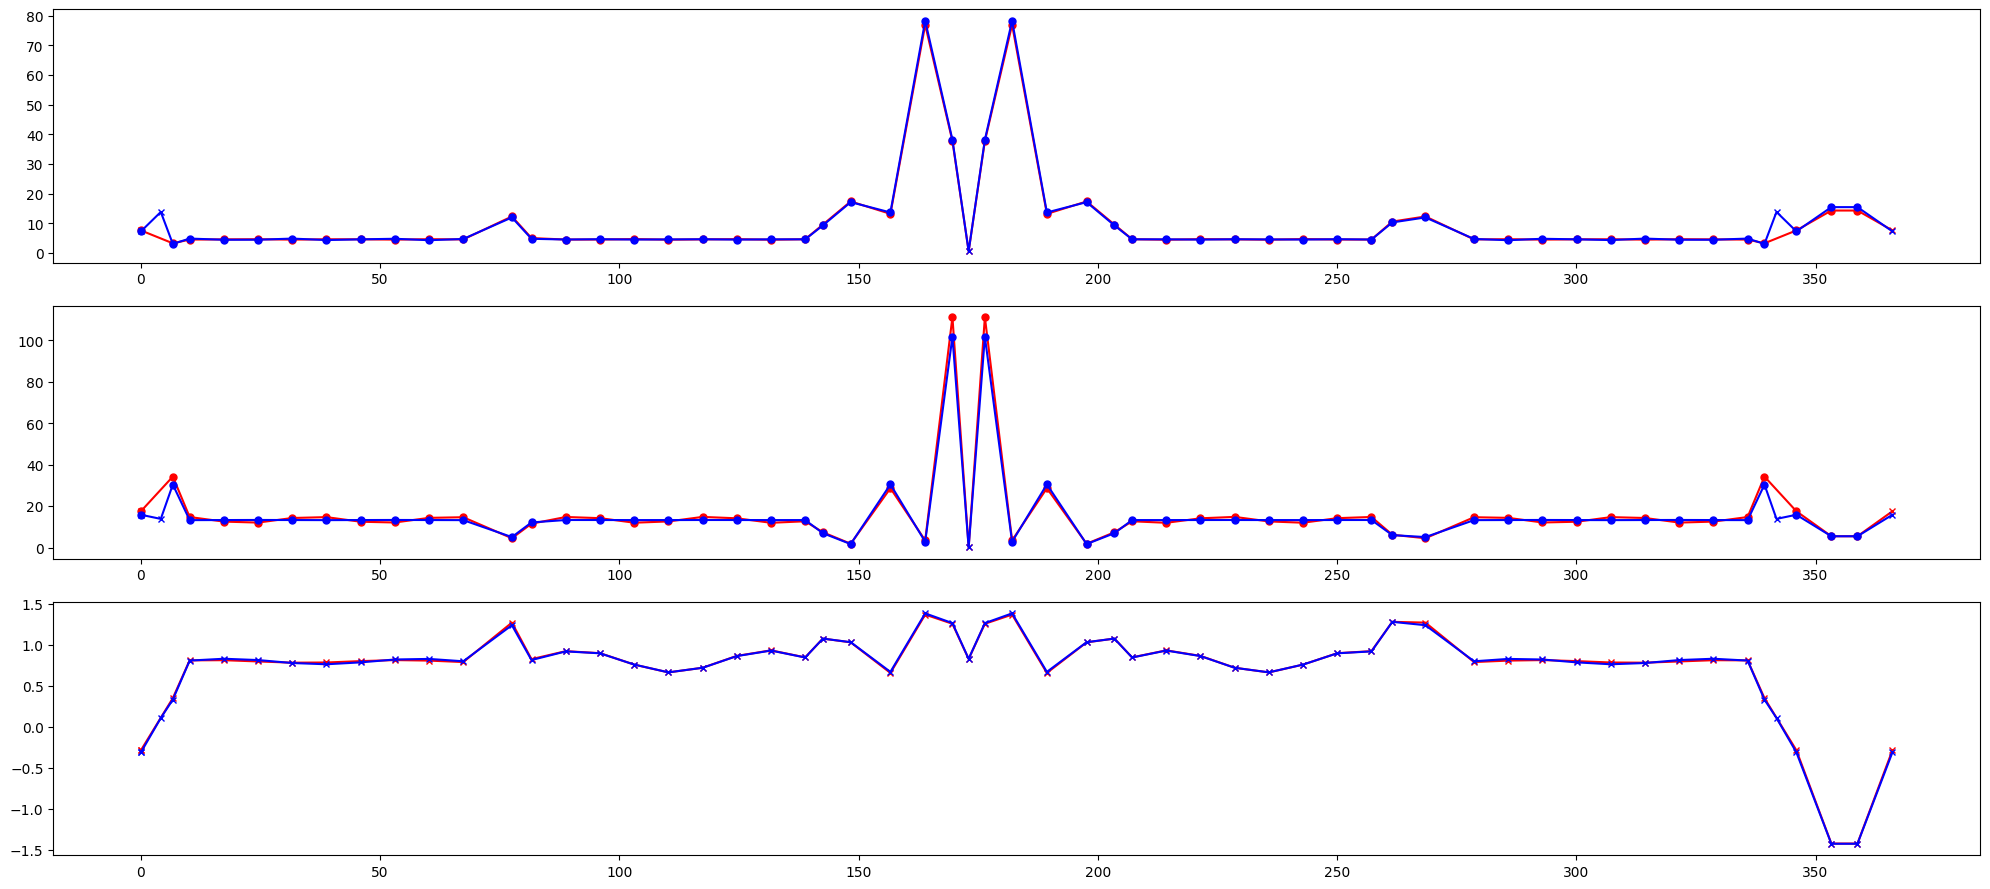

In [12]:
# Compare beta functions and dispersion
# Note, dispersion only accessible via data_frame instance

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 3*3))

ax1.errorbar(lum.time[lum.monitor_index].cpu().numpy(), lum.bx[lum.monitor_index].cpu().numpy(), fmt=' ', marker='o', ms=5, color='red')
ax1.errorbar(lum.time[lum.virtual_index].cpu().numpy(), lum.bx[lum.virtual_index].cpu().numpy(), fmt=' ', marker='x', ms=5, color='red')
ax1.errorbar(lum.time.cpu().numpy(), lum.bx.cpu().numpy(), marker='', ms=5, color='red')
ax1.errorbar(exp.time[exp.monitor_index].cpu().numpy(), exp.bx[exp.monitor_index].cpu().numpy(), fmt=' ', marker='o', ms=5, color='blue')
ax1.errorbar(exp.time[exp.virtual_index].cpu().numpy(), exp.bx[exp.virtual_index].cpu().numpy(), fmt=' ', marker='x', ms=5, color='blue')
ax1.errorbar(exp.time.cpu().numpy(), exp.bx.cpu().numpy(), marker='', ms=5, color='blue')

ax2.errorbar(lum.time[lum.monitor_index].cpu().numpy(), lum.by[lum.monitor_index].cpu().numpy(), fmt=' ', marker='o', ms=5, color='red')
ax2.errorbar(lum.time[lum.virtual_index].cpu().numpy(), lum.by[lum.virtual_index].cpu().numpy(), fmt=' ', marker='x', ms=5, color='red')
ax2.errorbar(lum.time.cpu().numpy(), lum.by.cpu().numpy(), marker='', ms=5, color='red')
ax2.errorbar(exp.time[exp.monitor_index].cpu().numpy(), exp.by[exp.monitor_index].cpu().numpy(), fmt=' ', marker='o', ms=5, color='blue')
ax2.errorbar(exp.time[exp.virtual_index].cpu().numpy(), exp.by[exp.virtual_index].cpu().numpy(), fmt=' ', marker='x', ms=5, color='blue')
ax2.errorbar(exp.time.cpu().numpy(), exp.by.cpu().numpy(), marker='', ms=5, color='blue')

ax3.errorbar(lum.time.cpu().numpy(), lum.data_frame.loc['DX'].values, marker='x', ms=5, color='red')
ax3.errorbar(exp.time.cpu().numpy(), exp.data_frame.loc['DX'].values, marker='x', ms=5, color='blue')

plt.tight_layout()
plt.show()

# IC (config from elegant twiss table)

In [1]:
rise = {'BPM05': 0, 'BPM07': 0, 'BPM08': 0, 'BPM09': 0, 'BPM10': 0, 'BPM11': 0, 'BPM12': 0, 'BPM13': 0, 'BPM14': 0, 'BPM15': 0, 'BPM16': 0, 'BPM17': 0, 'BPM01': 0, 'BPM02': 0, 'BPM03': 0, 'BPM04': 0}

def generate(file, *, rise=rise, kinds={'MONI': 'MONITOR', 'MULT': 'VIRTUAL'}):
    NAME = !(sdds2stream -col=ElementName $file)
    KIND = !(sdds2stream -col=ElementType $file)
    TIME = !(sdds2stream -col=s $file)
    NAME = [*map(str.strip, NAME)]
    KIND = [*map(str.strip, KIND)]
    TIME = [*map(str.strip, TIME)]

    AX = !(sdds2stream -col=alphax $file)
    BX = !(sdds2stream -col=betax $file)
    FX = !(sdds2stream -col=psix $file)
    DX = !(sdds2stream -col=etax $file)
    PX = !(sdds2stream -col=etaxp $file)
    AX = [*map(str.strip, AX)]
    BX = [*map(str.strip, BX)]
    FX = [*map(str.strip, FX)]
    DX = [*map(str.strip, DX)]
    PX = [*map(str.strip, PX)]

    AY = !(sdds2stream -col=alphay $file)
    BY = !(sdds2stream -col=betay $file)
    FY = !(sdds2stream -col=psiy $file)
    DY = !(sdds2stream -col=etay $file)
    PY = !(sdds2stream -col=etayp $file)
    AY = [*map(str.strip, AY)]
    BY = [*map(str.strip, BY)]
    FY = [*map(str.strip, FY)]
    DY = [*map(str.strip, DY)]
    PY = [*map(str.strip, PY)]
    
    TABLE = {}
    LID = 0
    KID = 0
    for data in  zip(NAME, KIND, TIME, AX, BX, FX, DX, PX, AY, BY, FY, DY, PY):
        name, kind, time, ax, bx, fx, dx, px, ay, by, fy, dy, py = data
        if kind not in kinds or name == '_BEG_':
            continue
        table = {
            'NAME':name,
            'LID':LID,
            'KID':KID,
            'TYPE':kinds[kind],
            'FLAG': int(name not in ['HEAD', 'TAIL']),
            'JOIN': int(kinds[kind] == 'MONITOR'),
            'RISE': rise.get(name, -1),
            'TIME': float(time),
            'AX': float(ax), 'BX': float(bx), 'FX': float(fx), 'DX': float(dx), 'PX': float(px),
            'AY': float(ay), 'BY': float(by), 'FY': float(fy), 'DY': float(dy), 'PY': float(py),
            'SIGMA_AX': 0.0, 'SIGMA_BX': 0.0, 'SIGMA_FX': 0.0, 'SIGMA_DX': 0.0, 'SIGMA_PX': 0.0,
            'SIGMA_AY': 0.0, 'SIGMA_BY': 0.0, 'SIGMA_FY': 0.0, 'SIGMA_DY': 0.0, 'SIGMA_PY': 0.0
        }
        if name not in TABLE:
            TABLE[name] = table
            KID +=1
        else:
            table['KID'] = TABLE[name]['KID']
            index = 0
            while True:
                index += 1
                if f'{name}-{index}' not in TABLE:
                    TABLE[f'{name}-{index}'] = table
                    break
        LID += 1
        

    MODEL = ''
    for key, value in TABLE.items():
        MODEL += f'{key:16}:  '
        MODEL += '{'
        MODEL += f'NAME: {value["NAME"]:16}, '
        MODEL += f'TYPE: {value["TYPE"]:16}, '
        MODEL += f'LID: {value["LID"]:4}, '
        MODEL += f'KID: {value["KID"]:4}, '
        MODEL += f'FLAG: {value["FLAG"]:2}, '
        MODEL += f'JOIN: {value["JOIN"]:2}, '
        MODEL += f'RISE: {value["RISE"]:2}, '
        MODEL += f'TIME: {value["TIME"]:24.16E}, '
        MODEL += f'AX: {value["AX"]:24.16E}, '
        MODEL += f'BX: {value["BX"]:24.16E}, '
        MODEL += f'FX: {value["FX"]:24.16E}, '
        MODEL += f'DX: {value["DX"]:24.16E}, '
        MODEL += f'PX: {value["PX"]:24.16E}, '
        MODEL += f'AY: {value["AY"]:24.16E}, '
        MODEL += f'BY: {value["BY"]:24.16E}, '
        MODEL += f'FY: {value["FY"]:24.16E}, '
        MODEL += f'DY: {value["DY"]:24.16E}, '
        MODEL += f'PY: {value["PY"]:24.16E}, '
        MODEL += f'SIGMA_AX: {value["SIGMA_AX"]:24.16E}, '
        MODEL += f'SIGMA_BX: {value["SIGMA_BX"]:24.16E}, '
        MODEL += f'SIGMA_FX: {value["SIGMA_FX"]:24.16E}, '
        MODEL += f'SIGMA_DX: {value["SIGMA_DX"]:24.16E}, '
        MODEL += f'SIGMA_PX: {value["SIGMA_PX"]:24.16E}, '
        MODEL += f'SIGMA_AY: {value["SIGMA_AY"]:24.16E}, '
        MODEL += f'SIGMA_BY: {value["SIGMA_BY"]:24.16E}, '
        MODEL += f'SIGMA_FY: {value["SIGMA_FY"]:24.16E}, '
        MODEL += f'SIGMA_DY: {value["SIGMA_DY"]:24.16E}, '
        MODEL += f'SIGMA_PY: {value["SIGMA_PY"]:24.16E}'
        MODEL += '}\n'

    return MODEL

In [2]:
with open('ic.yaml', mode='w') as stream:
    stream.write(generate('ic.sdds'))

In [3]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.model import Model

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [5]:
# Load inj and exp models

ic = Model(path='ic.yaml')

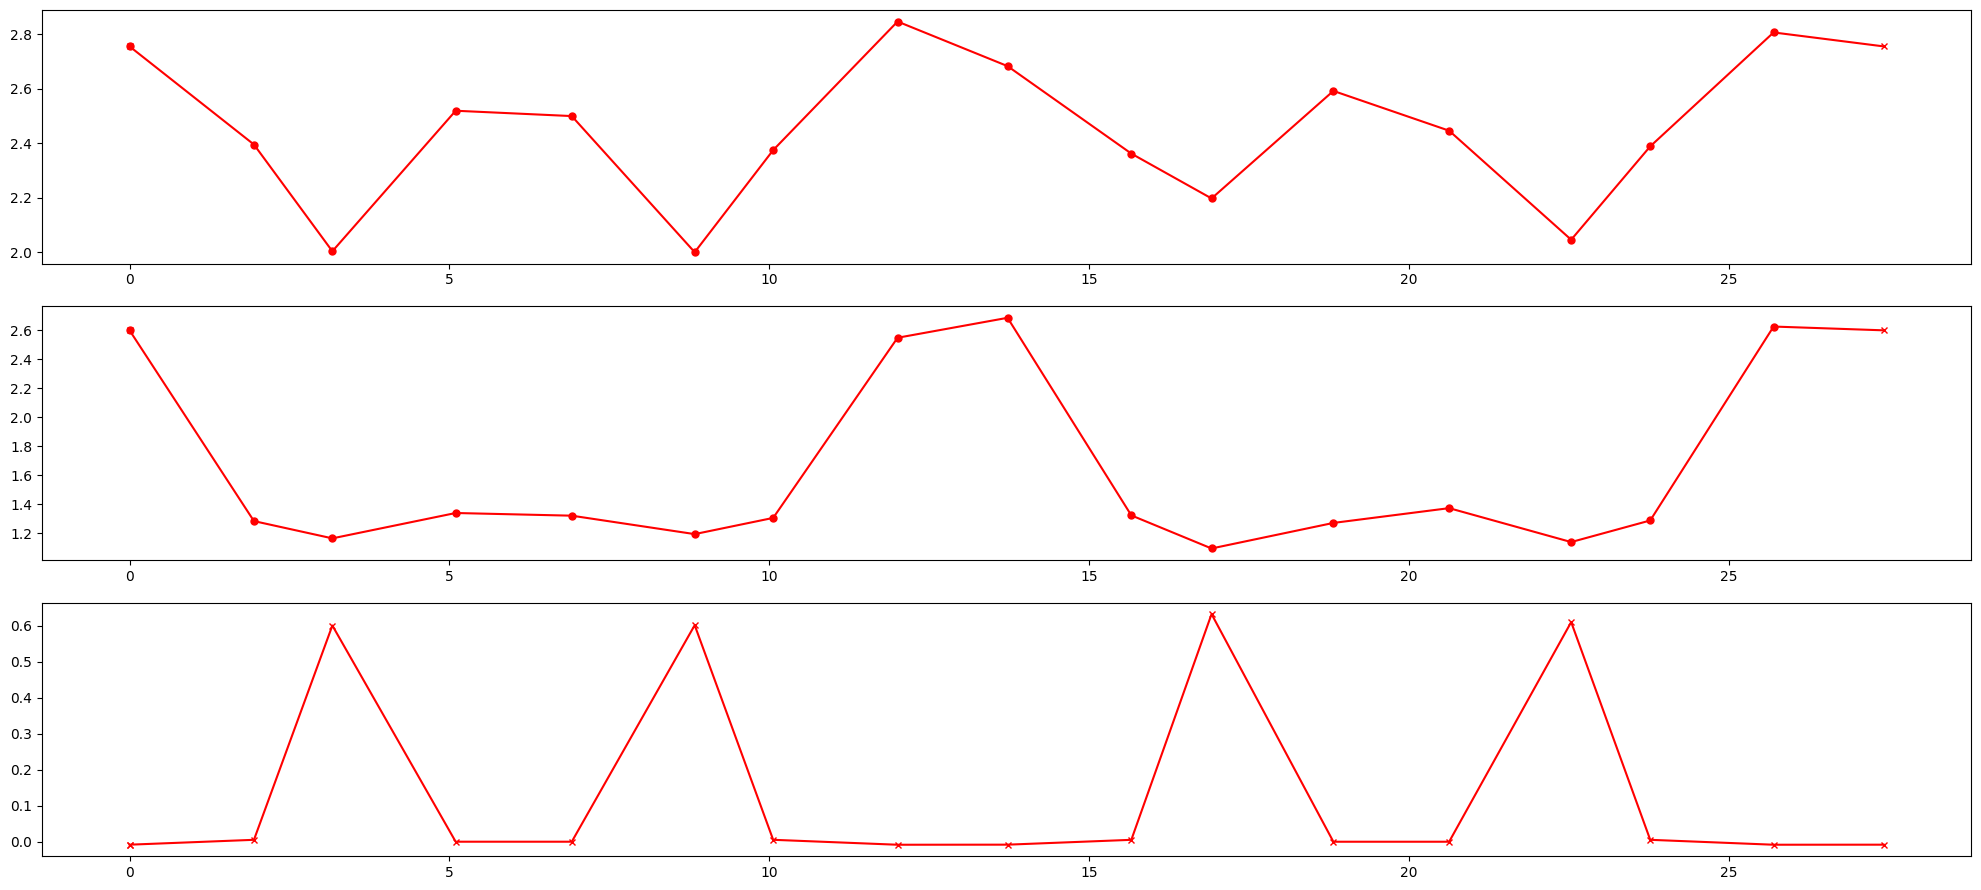

In [6]:
# Compare beta functions and dispersion
# Note, dispersion only accessible via data_frame instance

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 3*3))

ax1.errorbar(ic.time[ic.monitor_index].cpu().numpy(), ic.bx[ic.monitor_index].cpu().numpy(), fmt=' ', marker='o', ms=5, color='red')
ax1.errorbar(ic.time[ic.virtual_index].cpu().numpy(), ic.bx[ic.virtual_index].cpu().numpy(), fmt=' ', marker='x', ms=5, color='red')
ax1.errorbar(ic.time.cpu().numpy(), ic.bx.cpu().numpy(), marker='', ms=5, color='red')

ax2.errorbar(ic.time[ic.monitor_index].cpu().numpy(), ic.by[ic.monitor_index].cpu().numpy(), fmt=' ', marker='o', ms=5, color='red')
ax2.errorbar(ic.time[ic.virtual_index].cpu().numpy(), ic.by[ic.virtual_index].cpu().numpy(), fmt=' ', marker='x', ms=5, color='red')
ax2.errorbar(ic.time.cpu().numpy(), ic.by.cpu().numpy(), marker='', ms=5, color='red')

ax3.errorbar(ic.time.cpu().numpy(), ic.data_frame.loc['DX'].values, marker='x', ms=5, color='red')

plt.tight_layout()
plt.show()

# ELETTRA (config from elegant twiss table)

In [1]:
def generate(file, *, kinds={'MONI': 'MONITOR', 'MARK': 'VIRTUAL'}):

    NAME = !(sdds2stream -col=ElementName $file)
    KIND = !(sdds2stream -col=ElementType $file)
    TIME = !(sdds2stream -col=s $file)
    NAME = [*map(str.strip, NAME)]
    KIND = [*map(str.strip, KIND)]
    TIME = [*map(str.strip, TIME)]

    AX = !(sdds2stream -col=alphax $file)
    BX = !(sdds2stream -col=betax $file)
    FX = !(sdds2stream -col=psix $file)
    DX = !(sdds2stream -col=etax $file)
    PX = !(sdds2stream -col=etaxp $file)
    AX = [*map(str.strip, AX)]
    BX = [*map(str.strip, BX)]
    FX = [*map(str.strip, FX)]
    DX = [*map(str.strip, DX)]
    PX = [*map(str.strip, PX)]

    AY = !(sdds2stream -col=alphay $file)
    BY = !(sdds2stream -col=betay $file)
    FY = !(sdds2stream -col=psiy $file)
    DY = !(sdds2stream -col=etay $file)
    PY = !(sdds2stream -col=etayp $file)
    AY = [*map(str.strip, AY)]
    BY = [*map(str.strip, BY)]
    FY = [*map(str.strip, FY)]
    DY = [*map(str.strip, DY)]
    PY = [*map(str.strip, PY)]
    
    TABLE = {}
    LID = 0
    KID = 0
    for data in  zip(NAME, KIND, TIME, AX, BX, FX, DX, PX, AY, BY, FY, DY, PY):
        name, kind, time, ax, bx, fx, dx, px, ay, by, fy, dy, py = data
        if kind not in kinds:
            continue
        if name == '_BEG_': name = 'HEAD'
        if name == 'END_MARKER': name = 'TAIL'            
        if kind == "MARK" and not name.startswith('M'):
            if name not in ['HEAD', 'TAIL']:
                continue
        table = {
            'NAME': name,
            'LID': LID,
            'KID': KID,
            'TYPE': kinds[kind],
            'FLAG': int(name not in ['HEAD', 'TAIL']),
            'JOIN': int(kinds[kind] == 'MONITOR'),
            'RISE': 0,
            'TIME': float(time),
            'AX': float(ax), 'BX': float(bx), 'FX': float(fx), 'DX': float(dx), 'PX': float(px),
            'AY': float(ay), 'BY': float(by), 'FY': float(fy), 'DY': float(dy), 'PY': float(py),
            'SIGMA_AX': 0.0, 'SIGMA_BX': 0.0, 'SIGMA_FX': 0.0, 'SIGMA_DX': 0.0, 'SIGMA_PX': 0.0,
            'SIGMA_AY': 0.0, 'SIGMA_BY': 0.0, 'SIGMA_FY': 0.0, 'SIGMA_DY': 0.0, 'SIGMA_PY': 0.0
        }
        if name not in TABLE:
            TABLE[name] = table
            KID +=1
        else:
            table['KID'] = TABLE[name]['KID']
            index = 0
            while True:
                index += 1
                if f'{name}-{index}' not in TABLE:
                    TABLE[f'{name}-{index}'] = table
                    break
        LID += 1
        

    MODEL = ''
    for key, value in TABLE.items():
        MODEL += f'{key:16}:  '
        MODEL += '{'
        MODEL += f'NAME: {value["NAME"]:16}, '
        MODEL += f'TYPE: {value["TYPE"]:16}, '
        MODEL += f'LID: {value["LID"]:4}, '
        MODEL += f'KID: {value["KID"]:4}, '
        MODEL += f'FLAG: {value["FLAG"]:2}, '
        MODEL += f'JOIN: {value["JOIN"]:2}, '
        MODEL += f'RISE: {value["RISE"]:2}, '
        MODEL += f'TIME: {value["TIME"]:24.16E}, '
        MODEL += f'AX: {value["AX"]:24.16E}, '
        MODEL += f'BX: {value["BX"]:24.16E}, '
        MODEL += f'FX: {value["FX"]:24.16E}, '
        MODEL += f'DX: {value["DX"]:24.16E}, '
        MODEL += f'PX: {value["PX"]:24.16E}, '
        MODEL += f'AY: {value["AY"]:24.16E}, '
        MODEL += f'BY: {value["BY"]:24.16E}, '
        MODEL += f'FY: {value["FY"]:24.16E}, '
        MODEL += f'DY: {value["DY"]:24.16E}, '
        MODEL += f'PY: {value["PY"]:24.16E}, '
        MODEL += f'SIGMA_AX: {value["SIGMA_AX"]:24.16E}, '
        MODEL += f'SIGMA_BX: {value["SIGMA_BX"]:24.16E}, '
        MODEL += f'SIGMA_FX: {value["SIGMA_FX"]:24.16E}, '
        MODEL += f'SIGMA_DX: {value["SIGMA_DX"]:24.16E}, '
        MODEL += f'SIGMA_PX: {value["SIGMA_PX"]:24.16E}, '
        MODEL += f'SIGMA_AY: {value["SIGMA_AY"]:24.16E}, '
        MODEL += f'SIGMA_BY: {value["SIGMA_BY"]:24.16E}, '
        MODEL += f'SIGMA_FY: {value["SIGMA_FY"]:24.16E}, '
        MODEL += f'SIGMA_DY: {value["SIGMA_DY"]:24.16E}, '
        MODEL += f'SIGMA_PY: {value["SIGMA_PY"]:24.16E}'
        MODEL += '}\n'

    return MODEL

In [2]:
with open('elettra.yaml', mode='w') as stream:
    stream.write(generate('elettra.sdds'))

In [3]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.model import Model

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [5]:
# Load inj and exp models

elettra = Model(path='elettra.yaml')

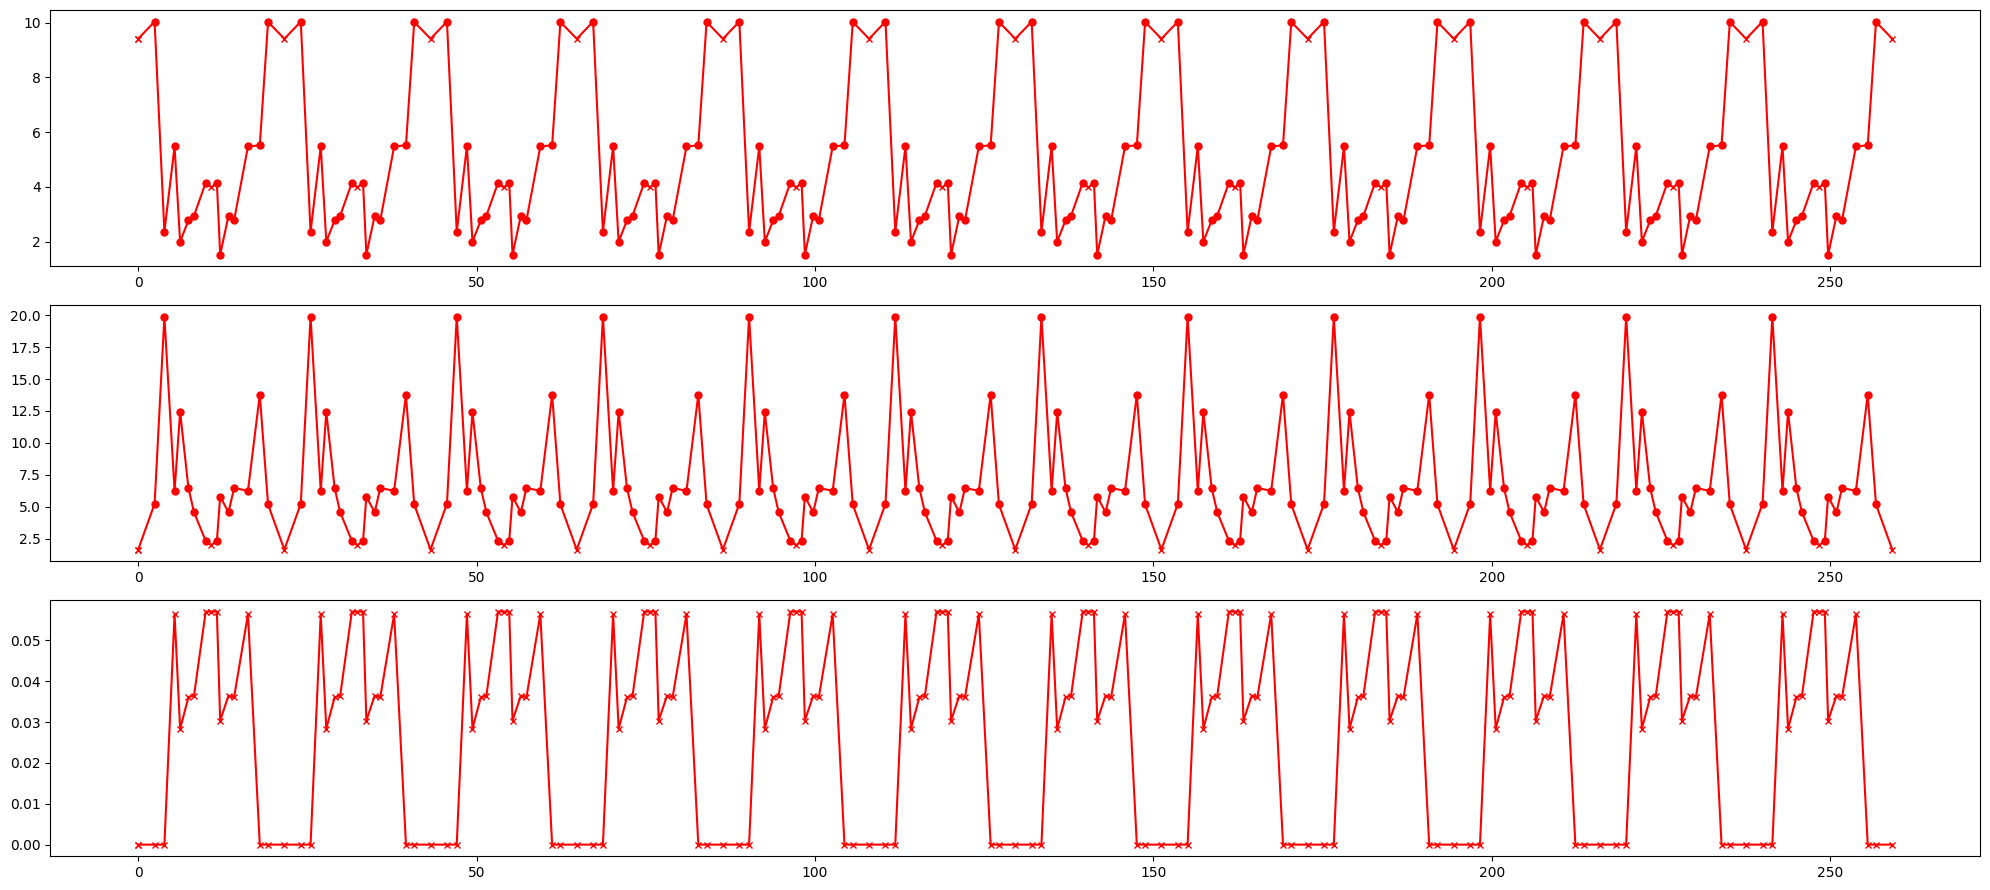

In [6]:
# Compare beta functions and dispersion
# Note, dispersion only accessible via data_frame instance

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 3*3))

ax1.errorbar(elettra.time[elettra.monitor_index].cpu().numpy(), elettra.bx[elettra.monitor_index].cpu().numpy(), fmt=' ', marker='o', ms=5, color='red')
ax1.errorbar(elettra.time[elettra.virtual_index].cpu().numpy(), elettra.bx[elettra.virtual_index].cpu().numpy(), fmt=' ', marker='x', ms=5, color='red')
ax1.errorbar(elettra.time.cpu().numpy(), elettra.bx.cpu().numpy(), marker='', ms=5, color='red')

ax2.errorbar(elettra.time[elettra.monitor_index].cpu().numpy(), elettra.by[elettra.monitor_index].cpu().numpy(), fmt=' ', marker='o', ms=5, color='red')
ax2.errorbar(elettra.time[elettra.virtual_index].cpu().numpy(), elettra.by[elettra.virtual_index].cpu().numpy(), fmt=' ', marker='x', ms=5, color='red')
ax2.errorbar(elettra.time.cpu().numpy(), elettra.by.cpu().numpy(), marker='', ms=5, color='red')

ax3.errorbar(elettra.time.cpu().numpy(), elettra.data_frame.loc['DX'].values, marker='x', ms=5, color='red')

plt.tight_layout()
plt.show()